In [1]:
from collections import defaultdict

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
model = resnet50()
model.fc = torch.nn.Linear(model.fc.in_features, 42)

model.load_state_dict(torch.load('best_model_state_dict_sampler.pth'))
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [32]:
test_dataset = datasets.ImageFolder(root='orig_dataset_norm_val/test/',
                                     transform=test_transform)

In [33]:
test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=1,
                              shuffle=False)

In [34]:
print(f"{len(test_dataset)} images, {len(test_dataset.classes)} classes")

4381 images, 42 classes


In [35]:
class_names = test_dataset.classes

In [36]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        preds = model(X)
        preds = preds.cpu().detach()
        preds = torch.argmax(preds, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

In [37]:
def accuracy_and_f1(all_preds, all_labels):
  f1_scores = []
  avg_accuracy = 0.0

  class_correct = defaultdict(int)
  class_total = defaultdict(int)

  for true_label, pred_label in zip(all_labels, all_preds):
      class_correct[true_label] += (true_label == pred_label)
      class_total[true_label] += 1

  f1_scores = f1_score(all_labels, all_preds, average=None, labels=list(range(len(class_names))))
  for class_label in sorted(class_correct.keys()):
      accuracy = class_correct[class_label] / class_total[class_label]
      avg_accuracy += accuracy
      print(f"Class {class_label} {class_names[class_label]}   :  Accuracy  {100*accuracy:.4f}%,   F1-Score  {f1_scores[class_label]:.4f}")
  avg_accuracy /= len(class_names)
  avg_f1 = f1_score(all_labels, all_preds, average='weighted')
  print(f"Average accuracy: {avg_accuracy}\n")
  print(f"Average F1-Score: {avg_f1}")

In [38]:
def class_precision_and_recall(all_preds, all_labels):
    precision_scores = precision_score(all_labels, all_preds, average=None, labels=list(range(len(class_names))))
    recall_scores = recall_score(all_labels, all_preds, average=None, labels=list(range(len(class_names))))
    for class_label in range(len(class_names)):
        print(f"Class {class_label} {class_names[class_label]}   :  Precision  {100*precision_scores[class_label]:.4f}%,   Recall  {100*recall_scores[class_label]:.4f}%")

    avg_precision = precision_score(all_labels, all_preds, average='macro')
    avg_recall = recall_score(all_labels, all_preds, average='macro')

    print(f"Average precision: {avg_precision:.4f}")
    print(f"Average recall: {avg_recall:.4f}\n")

In [39]:
class_precision_and_recall(all_preds, all_labels)

Class 0 abraham_grampa_simpson   :  Precision  97.2527%,   Recall  96.7213%
Class 1 agnes_skinner   :  Precision  91.3043%,   Recall  91.3043%
Class 2 apu_nahasapeemapetilon   :  Precision  99.1870%,   Recall  97.6000%
Class 3 barney_gumble   :  Precision  87.5000%,   Recall  95.4545%
Class 4 bart_simpson   :  Precision  98.5019%,   Recall  97.7695%
Class 5 carl_carlson   :  Precision  100.0000%,   Recall  90.0000%
Class 6 charles_montgomery_burns   :  Precision  92.8287%,   Recall  97.4895%
Class 7 chief_wiggum   :  Precision  95.5446%,   Recall  97.4747%
Class 8 cletus_spuckler   :  Precision  96.0000%,   Recall  96.0000%
Class 9 comic_book_guy   :  Precision  100.0000%,   Recall  97.8723%
Class 10 disco_stu   :  Precision  92.3077%,   Recall  75.0000%
Class 11 edna_krabappel   :  Precision  94.7368%,   Recall  97.8261%
Class 12 fat_tony   :  Precision  94.7368%,   Recall  85.7143%
Class 13 gil   :  Precision  100.0000%,   Recall  61.9048%
Class 14 groundskeeper_willie   :  Precision

In [40]:
class_accuracy_and_f1(all_preds, all_labels)

Class 0 abraham_grampa_simpson   :  Accuracy  96.7213%,   F1-Score  0.9699
Class 1 agnes_skinner   :  Accuracy  91.3043%,   F1-Score  0.9130
Class 2 apu_nahasapeemapetilon   :  Accuracy  97.6000%,   F1-Score  0.9839
Class 3 barney_gumble   :  Accuracy  95.4545%,   F1-Score  0.9130
Class 4 bart_simpson   :  Accuracy  97.7695%,   F1-Score  0.9813
Class 5 carl_carlson   :  Accuracy  90.0000%,   F1-Score  0.9474
Class 6 charles_montgomery_burns   :  Accuracy  97.4895%,   F1-Score  0.9510
Class 7 chief_wiggum   :  Accuracy  97.4747%,   F1-Score  0.9650
Class 8 cletus_spuckler   :  Accuracy  96.0000%,   F1-Score  0.9600
Class 9 comic_book_guy   :  Accuracy  97.8723%,   F1-Score  0.9892
Class 10 disco_stu   :  Accuracy  75.0000%,   F1-Score  0.8276
Class 11 edna_krabappel   :  Accuracy  97.8261%,   F1-Score  0.9626
Class 12 fat_tony   :  Accuracy  85.7143%,   F1-Score  0.9000
Class 13 gil   :  Accuracy  61.9048%,   F1-Score  0.7647
Class 14 groundskeeper_willie   :  Accuracy  100.0000%,   F1-

In [16]:
def print_prediction(model, test_data, class_names):
  model.eval()
  fig = plt.figure(figsize=(12,12))
  rows, cols = 4, 4
  for i in range (1, rows*cols+1):
    random_idx = torch.randint(0, len(test_data), size=[1]).item()
    img, label = test_data[random_idx]
    img = img.unsqueeze(0)
    img = img.to(device)
    pred_label = model(img).argmax(dim=1)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img.squeeze().cpu().numpy().transpose(1, 2, 0), cmap="gray")
    ax.set_title(f"true: {class_names[label]} \npred: {class_names[pred_label]}")
    ax.axis('off');

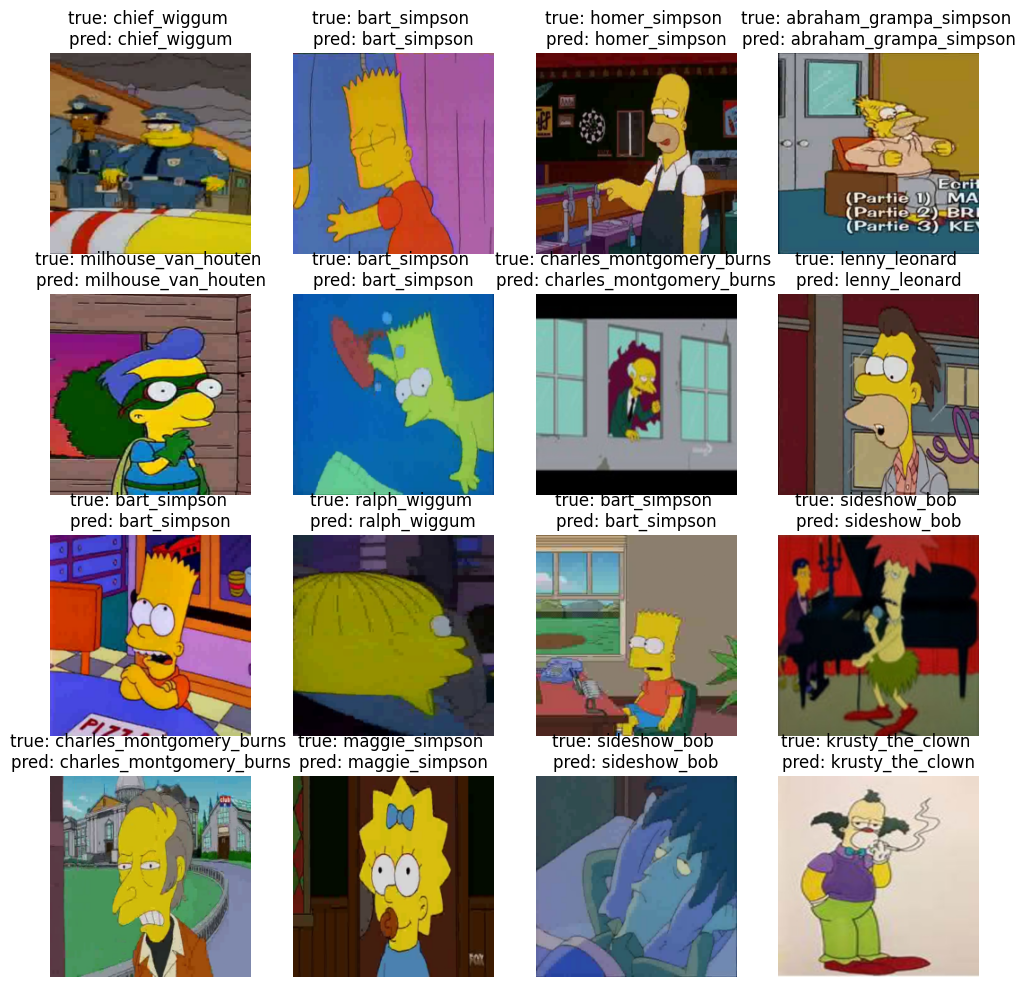

In [18]:
print_prediction(model, test_dataset, test_dataset.classes)